#  Install package

In [476]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install dash
# ! pip install altair
# ! pip install panel

# Import package

In [477]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai

# Define Solution class
Please run the following cell to define the functions

In [478]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration Cases

## Input task and data desciption

In [479]:
# Case 1: population living near hazardous wastes

'''
TASK = r"""1) Find out the total population that lives within a tract that contain hazardous waste facilities. The study area is North Carolina, US.
2) Generate a map to show the spatial distribution of population at the tract level and highlight the borders of tracts that have hazardous waste facilities.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.",
                  "NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.",
                  "NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID'."
                 ]


task_name ='Resident_at_risk_counting'
'''

# Case 2: mobility data retrieval and visulization
"""
TASK = r'''
1) Show the monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions.

'''

DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
                  "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip." + \
                  "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
                  "REST API url with parameters for mobility data access:" + \
                  "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
                  "The response is in CSV format. There are three columns in the response: " + \
                  "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code, France administrative regions start with 'FRA'.",
                 ]


# task_name ='France_mobility_changes_2020'
"""

# Case 3: COVID-19 prevalence trend
"""
task_name ='COVID_death_rate'
TASK = r'''1) Draw a map to show the death rate (death/case) of COVID-19 among the countiguous US counties in 2020. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate.
2) The map size is 15*10 inches, make it beautiful.  
3) Draw a scatter chart to show the correlation and trend line between the death rate and the senior resident rate, including the r-square and p-value.
'''

DATA_LOCATIONS = [
                  r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
                  r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'. ",
                  r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
                 ]

"""

# Case 4: Hospital_accessibility
task_name ='Hospital_accessibility'

TASK = r'''
For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map, also show the hospital.
'''

DATA_LOCATIONS = [
r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, map projection is WGS1984.",
r"SC hospitals:  https://raw.githubusercontent.com/GIBDUSC/test/master/SC_hospitals_with_emergency_room.csv, location columns: Latitude, Longitude",          
]

  
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 
For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map, also show the hospital.
 
Your reply needs to meet these requirements: 
 1. Think step by step.
2. Steps and data (both input and output) form a graph stored in NetworkX. Disconnected components are NOT allowed.
3. Each step is a data process operation: the input can be data paths or variables, and the output can be data paths or variables.
4. There are two types of nodes: a) operation node, and b) data node (both input and output data). These nodes are also input nodes for the next operation node.
5. The input of each operation is the output of the previous operation

## Get graph code from GPT API

In [480]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()
print()
# print("Code to generate solution graph: \n")
# print(solution.code_for_graph)

```python
import networkx as nx

G = nx.DiGraph()

# Load SC zipcode boundary shapefile
G.add_node("zipcode_shp_url", node_type="data", path="https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip", description="South Carolina zipcode boundary shapefile URL")
G.add_node("load_zipcode_shp", node_type="operation", description="Load South Carolina zipcode boundary shapefile")
G.add_edge("zipcode_shp_url", "load_zipcode_shp")
G.add_node("zipcode_gdf", node_type="data", description="SC zipcode boundary GeoDataFrame")
G.add_edge("load_zipcode_shp", "zipcode_gdf")

# Load SC hospitals with emergency room
G.add_node("hospitals_csv_url", node_type="data", path="https://raw.githubusercontent.com/GIBDUSC/test/master/SC_hospitals_with_emergency_room.csv", description="South Carolina hospitals with emergency room CSV URL")
G.add_node("load_hospitals_csv", node_type="operation", description="Load South Carolina hospitals with emergency room CSV")
G.add_edge("hospitals_csv_url", "load_hospita

## Execute code to generate the solution graphto generate the solution graph

In [481]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

E:\Research\LLM-Geo\Hospital_accessibility.html


## Generate prompts and code for operations (functions)

In [482]:
operations = solution.get_LLM_responses_for_operations()
solution.save_solution()

# all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])
# print("All operation code: \n")
# print(all_operation_code_str)

1 / 5, load_zipcode_shp
```python
import geopandas as gpd

def load_zipcode_shp(zipcode_shp_url="https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip"):
    """
    Load South Carolina zipcode boundary shapefile.

    Args:
    zipcode_shp_url (str): URL for the SC zipcode boundary shapefile (default: provided URL).

    Returns:
    zipcode_gdf (GeoDataFrame): GeoDataFrame containing SC zipcode boundary data.
    """
    zipcode_gdf = gpd.read_file(zipcode_shp_url)
    return zipcode_gdf
```



2 / 5, load_hospitals_csv
```python
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

def load_hospitals_csv(hospitals_csv_url="https://raw.githubusercontent.com/GIBDUSC/test/master/SC_hospitals_with_emergency_room.csv"):
    # Description: Load South Carolina hospitals with emergency room CSV
    # hospitals_csv_url: South Carolina hospitals with emergency room CSV file URL
    hospitals_df = pd.read_csv(hospitals_csv_url)
    hospitals_gdf = gpd.GeoData

In [483]:
all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])
# print(all_operation_code_str)

## Generate prompts and code for assembly program

In [484]:
assembly_LLM_response = solution.get_LLM_assembly_response()
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

# print("Assembly code: \n")
# print(solution.code_for_assembly)

```python
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pyproj

# Step 1: Load South Carolina zipcode boundary shapefile
zipcode_gdf = load_zipcode_shp()

# Step 2: Load South Carolina hospitals with emergency room CSV
hospitals_gdf = load_hospitals_csv()

# Step 3: Calculate the centroid of each SC zipcode area
zipcode_centroids = calc_zipcode_centroids(zipcode_gdf)

# Step 4: Calculate the distance from the centroid of each SC zipcode area to its nearest hospital
dist_to_nearest_hospital = calc_nearest_hospital_distance(hospitals_gdf, zipcode_centroids)

# Step 5: Create a choropleth distance map with hospitals
choropleth_map = create_choropleth_map(zipcode_gdf, dist_to_nearest_hospital)

# Step 6: Save the choropleth map
choropleth_map.savefig('choropleth_map_SC_distance_to_nearest_hospital.png', dpi=300)

plt.show()
```




## Execute assembly code

In [485]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly
print(solution.code_for_assembly)

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pyproj

# Step 1: Load South Carolina zipcode boundary shapefile
zipcode_gdf = load_zipcode_shp()

# Step 2: Load South Carolina hospitals with emergency room CSV
hospitals_gdf = load_hospitals_csv()

# Step 3: Calculate the centroid of each SC zipcode area
zipcode_centroids = calc_zipcode_centroids(zipcode_gdf)

# Step 4: Calculate the distance from the centroid of each SC zipcode area to its nearest hospital
dist_to_nearest_hospital = calc_nearest_hospital_distance(hospitals_gdf, zipcode_centroids)

# Step 5: Create a choropleth distance map with hospitals
choropleth_map = create_choropleth_map(zipcode_gdf, dist_to_nearest_hospital)

# Step 6: Save the choropleth map
choropleth_map.savefig('choropleth_map_SC_distance_to_nearest_hospital.png', dpi=300)

plt.show()


In [486]:
print(all_code)

import geopandas as gpd

def load_zipcode_shp(zipcode_shp_url="https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip"):
    """
    Load South Carolina zipcode boundary shapefile.

    Args:
    zipcode_shp_url (str): URL for the SC zipcode boundary shapefile (default: provided URL).

    Returns:
    zipcode_gdf (GeoDataFrame): GeoDataFrame containing SC zipcode boundary data.
    """
    zipcode_gdf = gpd.read_file(zipcode_shp_url)
    return zipcode_gdf
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

def load_hospitals_csv(hospitals_csv_url="https://raw.githubusercontent.com/GIBDUSC/test/master/SC_hospitals_with_emergency_room.csv"):
    # Description: Load South Carolina hospitals with emergency room CSV
    # hospitals_csv_url: South Carolina hospitals with emergency room CSV file URL
    hospitals_df = pd.read_csv(hospitals_csv_url)
    hospitals_gdf = gpd.GeoDataFrame(hospitals_df, geometry=gpd.points_from_xy(hospitals_df.Longitude, hospi

<string>:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



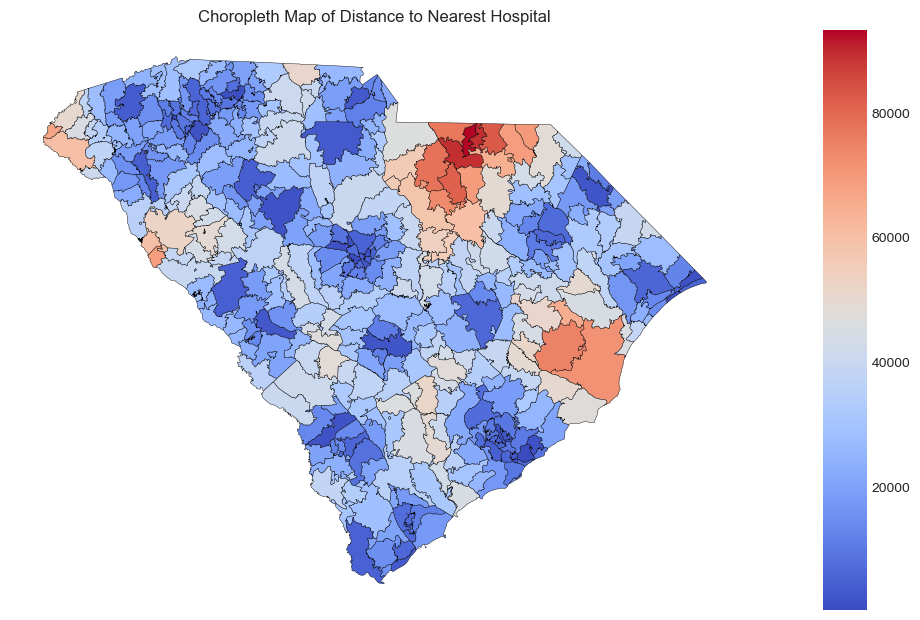

In [487]:
exec(all_code)

In [488]:
stop

NameError: name 'stop' is not defined